<a href="https://colab.research.google.com/github/aashutoshPanda/Machine-Learning/blob/master/House%20Price%20Prediction%20with%20Linear%20Reg%20Optimised%20by%20RandomSearchCV/house_price_prediction_linear_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Imports

In [35]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Collecting the dataset

In [31]:
DOWNLOAD_URL ="https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
DOWNLOAD_SAVE_PATH = os.path.join("datasets", "housing")
FILENAME_ON_SAVE = "housing.tgz"

def download_save_extract(url=DOWNLOAD_URL,save_path = DOWNLOAD_SAVE_PATH,filename = FILENAME_ON_SAVE):
  if not os.path.isdir(save_path):
        os.makedirs(save_path)
  zipped_file_location = os.path.join(save_path, filename)
  with open(zipped_file_location, "wb") as f:
        print (f"Downloading {zipped_file_location}")
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                sys.stdout.flush()
        print("DOWNLOAD COMPLETE")
  zipped_file_pointer = tarfile.open(zipped_file_location)
  zipped_file_pointer.extractall(path=save_path)
  zipped_file_pointer.close()
  print("EXTRACTION COMPLETE")


In [32]:
download_save_extract()

[==================================================]DOWNLOAD COMPLETE
EXTRACTION COMPLETE


# Preparing the data

#### Loading CSV as Dataframe

In [ ]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Stratified Shuffle Split

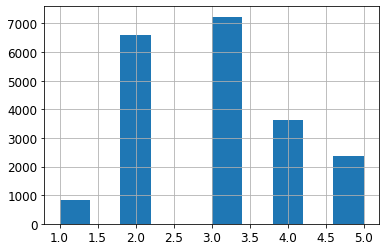

In [38]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [40]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND,4
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND,2
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND,3
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN,3


In [44]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

#### Dividing into features & target

In [45]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

#### Dividing into numerical & categorical

In [46]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

### Custom Estimator for adding more features

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


#### Pipeline for handling numerical features

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

#### Combining numerical & categorical pipeline

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#### Applying pipline to the dataframe

In [53]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Selecting & Training the models

#### Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Measuring the Error

In [55]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

# Hyperparameter Optimisation

In [67]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = RandomizedSearchCV(lin_reg, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(housing_prepared, housing_labels)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=500. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Score: -49555.362487704704
Best Hyperparameters: {'normalize': True, 'fit_intercept': False}


In [71]:
best_model = result.best_estimator_

In [72]:
from joblib import dump, load
dump(best_model, 'house_price_lin_reg.joblib') 

['house_price_lin_reg.joblib']